In [1]:
import pandas as pd
import numpy as np
import sys
import os
import cv2
import matplotlib.pyplot as plt
import random
from collections import Counter

Data sources: 

https://www.kaggle.com/datasets/fedesoriano/chinese-mnist-digit-recognizer

https://www.kaggle.com/datasets/oddrationale/mnist-in-csv?select=mnist_train.csv

We want 1000 of each 0-9 class (because this is the number the chinese MNIST has, which is the lowest of the two datasets). They also should be 28x28, which is the dimensions of the normal MNIST images, so the chinese one (64x64) needs to be reduced in a nice way. 

The imported functions "chineseMNISTreader" and "resizeAndCrop" do these things. The first just reads the csv file and returns the images (as a np array, where each image is a vector in one row), and the labels (a list of 0-9 integers). 

## To load all of the data:
Looks like this. The 'Images' is a numpy array with 1000 images per 0-9 class, where each image is a 784-long vector (28x28 pixel images). The 'Labels' is just a list of integers 0-9 corresponding to the images.

In [2]:
from src.dataLoading import loadChineseMNIST, loadNormalMNIST

## normal MNIST

samplesPerClass = 1000  # same number of samples per class as the whole chinese MNIST data
mnistVectors, mnistImages, mnistLabels = loadNormalMNIST()
# this function will just sample 1000 from the (roughly) 6000-7000 images per class in the whole mnist dataset
# so this sampling will return different images each time its run, 
# but adding a number for the random_state will ensure it always the same set (in case you want that):
"""
mnistImages, mnistLabels = loadNormalMNIST(samplesPerClass, random_state=42)
"""

## chinese MNIST
# this function does all the loading and preprocessing of the images
chineseVectors, chineseImages, chineseLabels = loadChineseMNIST()


In [3]:
print("instances per MNIST class", Counter(mnistLabels))
print("shape of MNIST image", mnistImages[0].shape)
print("shape of MNIST vectors", mnistVectors.shape)
print(" ")


print("instances per Chinese MNIST class", Counter(chineseLabels))
print("shape of Chinese image", chineseImages[0].shape)
print("shape of Chinese vectors", chineseVectors.shape)

instances per MNIST class Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000})
shape of MNIST image (28, 28)
shape of MNIST vectors (10000, 784)
 
instances per Chinese MNIST class Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000})
shape of Chinese image (28, 28)
shape of Chinese vectors (10000, 784)


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

# Chinese MNIST Demo 
Use whats above this to load them, not whats below this!! 


Everything below this is just to show how the data loading and processing works

### Image cropping & resizing demo

In [4]:
# import the functions I made
from src.dataLoading import chineseMNISTreader, resizeAndCrop

oldChineseVectors, chineseLabels = chineseMNISTreader()

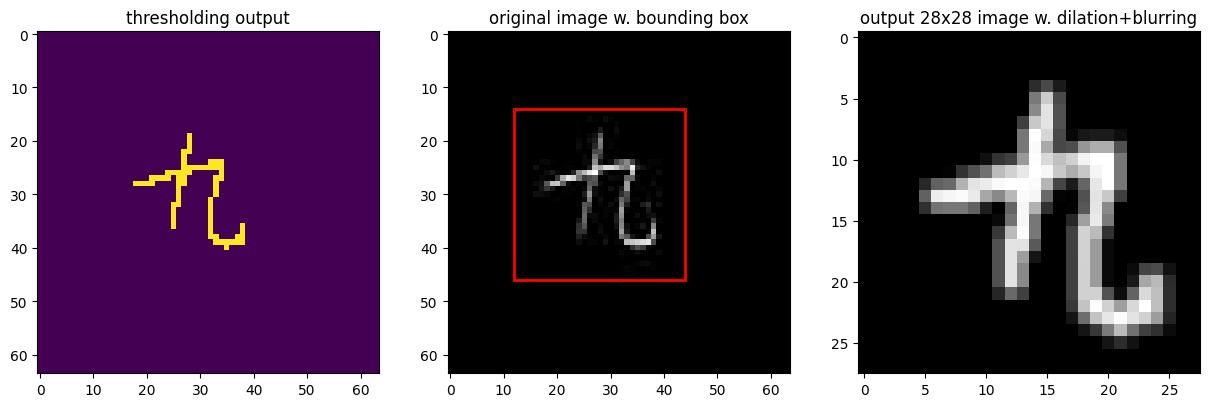

In [8]:
# you can keep rerunning this one!

from matplotlib.patches import Rectangle

# reshape a random data vector back into an image
vect = oldChineseVectors[random.randint(0, len(chineseImages))]
img = np.reshape(vect, (64,64)).astype('uint8')

# threshold 
ret, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
"""Sara's stuff"""
kernel = np.ones((2, 2), np.uint8) #also needs to be tuned
img_dil = cv2.dilate(img_bin, kernel, iterations=1)
#img_smth = gaussian_filter(img_bin, sigma= sigma)
#img_smth = cv2.GaussianBlur(img_dil,(3,3),sigmaX=0.6)
img_smth = cv2.blur(img_dil,(2,2))

"""the rest is the same"""
# get bounds of white pixels
white = np.where(img_bin==255)
xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])
yrange = ymax-ymin
xrange = xmax-xmin

# take the max of the width or height of the image, we'll use this to define the cropping
Range = yrange if yrange>xrange else xrange
if Range%2 != 0: # make sure its not odd
    Range += 1

x_center = int(np.round((xmax+xmin)/2))
y_center = int(np.round((ymax+ymin)/2))

size = int(Range/2 + 5) # pad all sides by 5 pixels

# the dimensions of the bounding box (prevent going off the edges of the image)
top = y_center-size if y_center-size > 0 else 0
bottom = y_center+size if y_center+size < 64 else 64
left = x_center-size if x_center-size > 0 else 0
right = x_center+size if x_center+size < 64 else 64

# crop the image and resize it
crop = img_smth[top : bottom, left : right]
resized_crop = cv2.resize(crop, (28,28))



# plotting, just to show whats happened
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(img_bin)
ax[0].set_title('thresholding output')
ax[1].imshow(img, cmap='gray')
ax[1].add_patch(Rectangle((left,top),Range+10,Range+10,linewidth=2,edgecolor='r',facecolor='none'))
ax[1].set_title('original image w. bounding box')
ax[2].imshow(resized_crop, cmap='gray')
ax[2].set_title('output 28x28 image w. dilation+blurring')
plt.show()

### Examples
Here I just sample 100 images of the original (chinese MNIST) dataset and show the results of the image processing code

In [9]:
def show_images(images, length, isTest=False):
    f, ax = plt.subplots(int(length/20),20, figsize=(20,int(length/20)))
    for index,vector in enumerate(images):
        img_size = int(len(vector)**0.5)
        img = np.reshape(vector, (img_size,img_size))
        ax[index//20, index%20].imshow(img, cmap='gray')
        ax[index//20, index%20].axis('off')
    plt.show()

ORGINAL 64x64 IMAGES


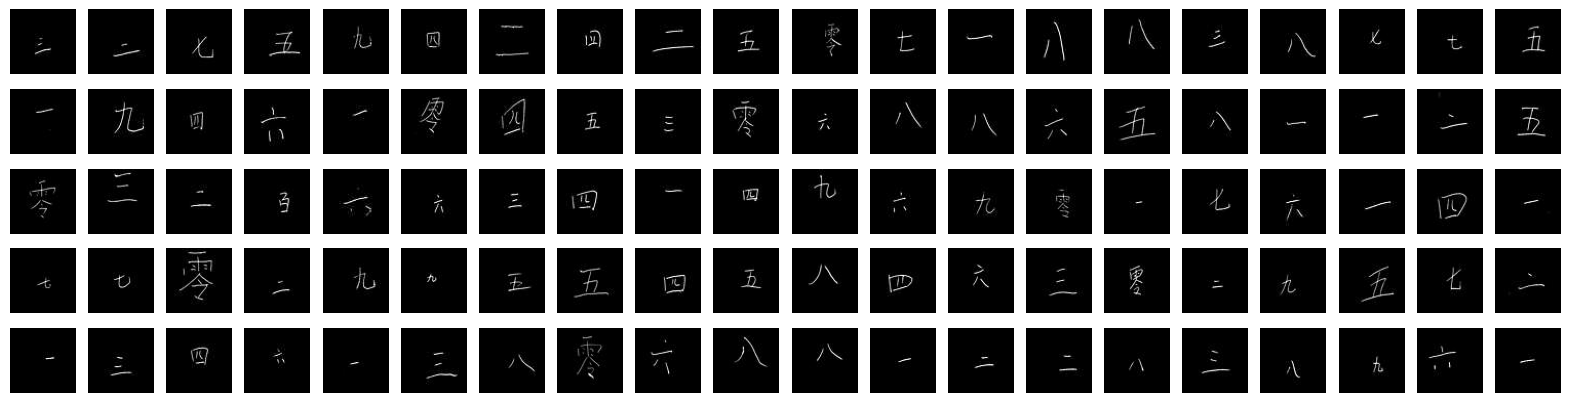

PROCESSED 28x28 IMAGES


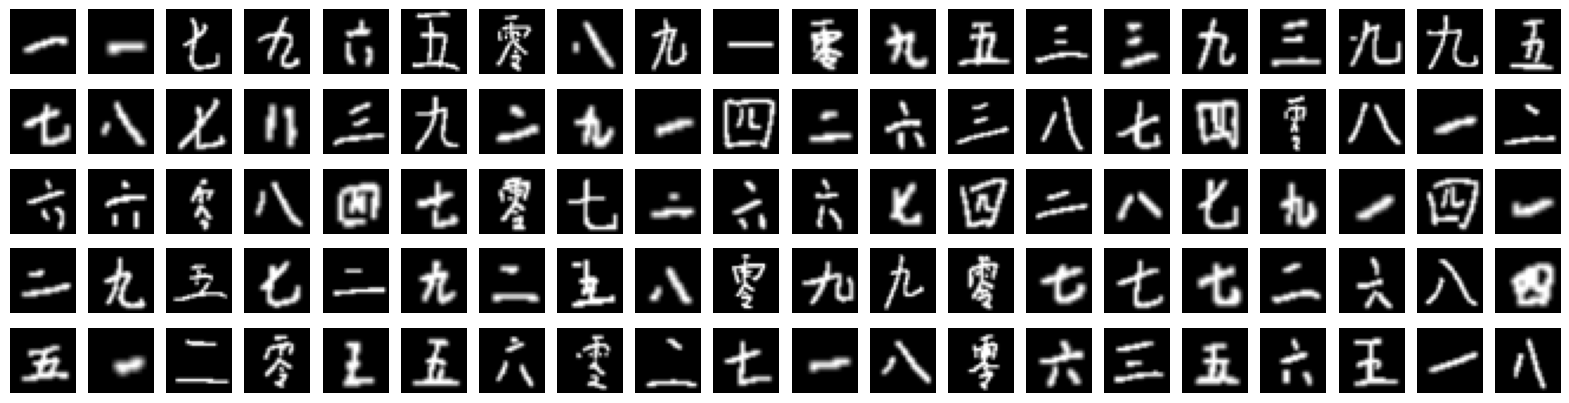

In [ ]:
# pick 100 random images from the dataset
picks = np.random.choice(len(chineseImages), size=100, replace=False)
sampleChineseVectors = oldChineseVectors[picks]
length = len(sampleChinese)

# plotting
print("ORGINAL 64x64 IMAGES")
show_images(sampleChinese, length)

newSampleChineseVectors, newSampleChineseImages = resizeAndCrop(sampleChineseVectors)

print("PROCESSED 28x28 IMAGES")
show_images(newSampleChineseVectors, length)

# Side-by-side
Just to show what both sets of 28x28 images look like now

MNIST images


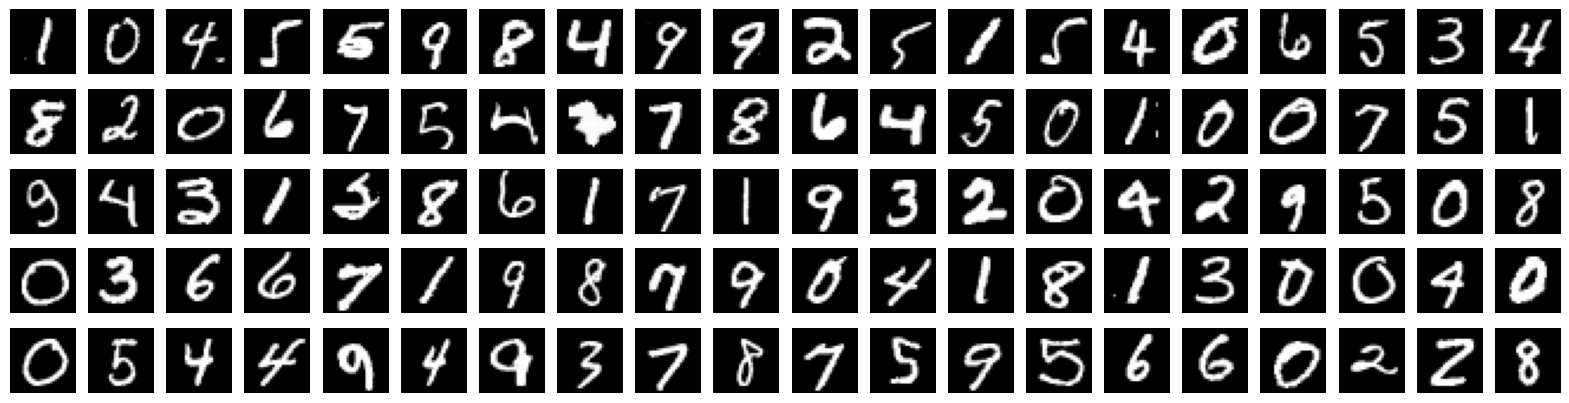

processed Chinese MNIST images


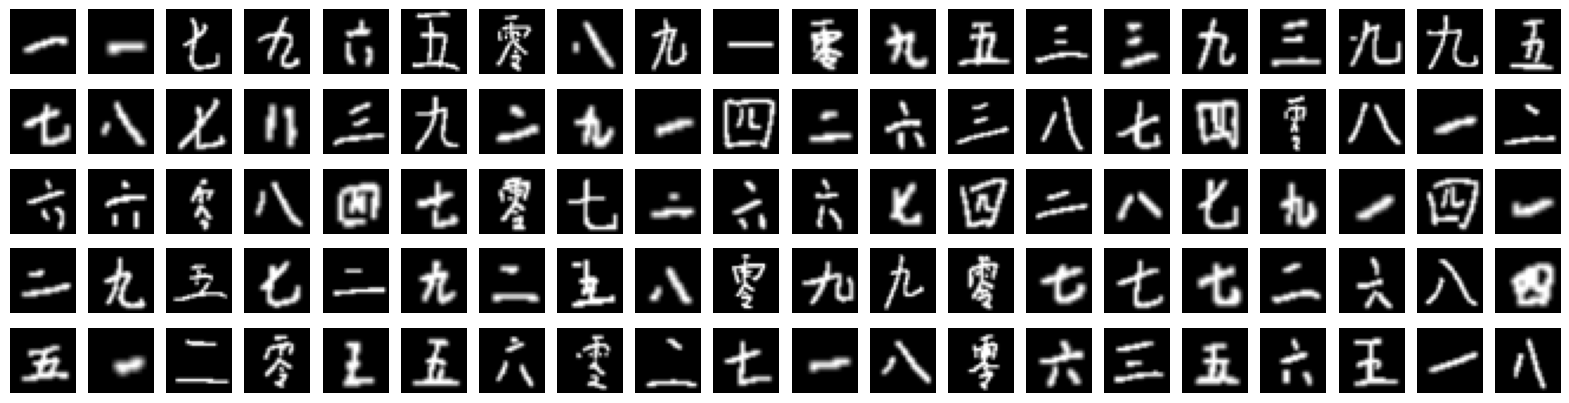

In [ ]:
# pick 100 random images from the dataset
picks = np.random.choice(len(mnistVectors), size=100, replace=False)
sampleMNIST = mnistVectors[picks]
length = len(sampleMNIST)


print("MNIST images")
show_images(sampleMNIST, length)
print("processed Chinese MNIST images")
show_images(newSampleChineseVectors, length)

### Lets see how an SVM does here then
(this can take a few minutes to run...)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


processedChineseVectors, ignore = resizeAndCrop(oldChineseVectors)

names = ["original chinese", "processed chinese", "mnist"]
data = [oldChineseVectors, processedChineseVectors, mnistImages]
labels = [chineseLabels, chineseLabels, mnistLabels]


for i in range(len(names)):
    print(names[i])

    X_train, X_test, y_train, y_test = train_test_split(data[i], labels[i], train_size=0.8, random_state=42)

    svm = SVC().fit(X_train, y_train)

    predictions = svm.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("acc:", accuracy)


original chinese
